In [177]:
import torch
import os
from PIL import Image
from pathlib import Path
from diffusers import StableDiffusionPipeline, DDIMScheduler
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker
from tqdm.auto import tqdm
import numpy as np
import torch.nn.functional as F

# Device configuration
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {torch_device}")

# Load the stable diffusion pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    torch_dtype=torch.float16,
    use_auth_token=True
).to(torch_device)

pipe.safety_checker = StableDiffusionSafetyChecker.from_pretrained(
    "CompVis/stable-diffusion-safety-checker", 
    torch_dtype=torch.float16
).to(torch_device)

# Setup components for easier access
vae = pipe.vae
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
unet = pipe.unet
scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

# Configuration
batch_size = 1
height = 512
width = 512
guidance_scale = 6.0
num_inference_steps = 50
airplane_guidance_scale = 100  # Similar to blue_loss_scale

Using device: cuda


Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...:  86%|████████▌ | 6/7 [00:03<00:00,  1.70it/s]c:\Users\Saish Shetty\.conda\envs\eraenv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


In [178]:
# 1. Add this at the beginning with your other component setups
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
position_embeddings = text_encoder.text_model.embeddings.position_embedding.weight

# 2. Add this helper function to get output embeddings
def get_output_embeds(input_embeddings):
    """Process input embeddings through the text encoder to get output embeddings"""
    with torch.no_grad():
        outputs = text_encoder.text_model.encoder(
            inputs_embeds=input_embeddings,
            attention_mask=torch.ones(
                input_embeddings.shape[0], input_embeddings.shape[1], 
                dtype=torch.float16, device=torch_device
            ),
        )
        # Get the output
        return text_encoder.text_model.final_layer_norm(outputs[0])

In [181]:
# Generate an image (for example)
result = pipe("A kid dancing on the beach.", batch_size=batch_size, height=height, width=width, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale, airplane_guidance_scale=airplane_guidance_scale)
image, has_nsfw_concepts = result.images, result.nsfw_content_detected

if has_nsfw_concepts:
    print("NSFW content detected; the image may be blurred or filtered.")
else:
    print("Image is safe!")

100%|██████████| 50/50 [00:05<00:00,  9.27it/s]


NSFW content detected; the image may be blurred or filtered.


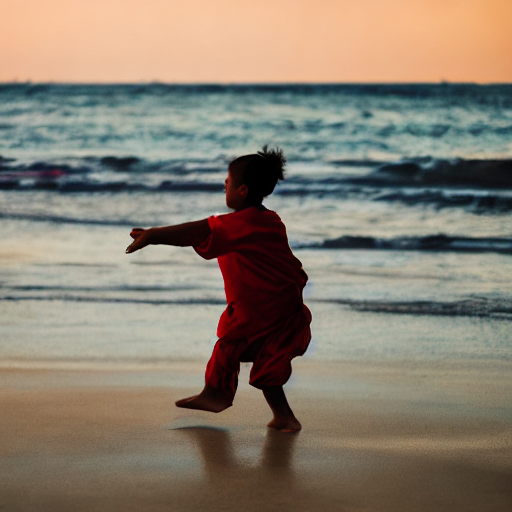

In [182]:
image[0]

In [121]:
new_token = "<my_concept>"
if new_token not in tokenizer.get_vocab():
    tokenizer.add_tokens([new_token])
    text_encoder.resize_token_embeddings(len(tokenizer))

In [122]:
# =============================================
# PART 1: Load the concept embeddings
# =============================================

# Dictionary to store concept embeddings with their respective tokens
concept_embeddings = {}
concepts = ["<anime-background-style-v2>", "<gta5-artwork>", "<line-art>", "<m-geo>", "<orientalist-art>"]  # Replace with your 5 concepts

# Load each concept embedding
for concept in concepts:
    concept_path = f"sd-concepts\\{concept.strip('<>')}-learned_embeds.bin"  # Adjust path as needed
    if os.path.exists(concept_path):
        embed_dict = torch.load(concept_path, map_location=torch_device)
        concept_token = list(embed_dict.keys())[0]  # Get the token
        concept_embeddings[concept] = embed_dict[concept_token]
        print(f"Loaded concept: {concept}")
    else:
        print(f"Warning: Embedding file for {concept} not found at {concept_path}")

Loaded concept: <anime-background-style-v2>
Loaded concept: <gta5-artwork>
Loaded concept: <line-art>
Loaded concept: <m-geo>
Loaded concept: <orientalist-art>


C:\Users\Saish Shetty\AppData\Local\Temp\ipykernel_16792\510860849.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embed_dict = torch.load(concept_path, map_location=to

In [123]:
# =============================================
# PART 2: Extract latent embeddings from airplane images
# =============================================

def extract_vae_latents(image_paths):
    """Extract VAE latent embeddings from a list of images."""
    latents_list = []
    
    for img_path in tqdm(image_paths, desc="Extracting latents"):
        # Load and preprocess image
        image = Image.open(img_path).convert("RGB")
        image = image.resize((width, height))
        
        # Convert to tensor and normalize
        image_tensor = torch.from_numpy(np.array(image)).float() / 255.0
        image_tensor = image_tensor.permute(2, 0, 1).unsqueeze(0).to(torch_device)  # [1, 3, H, W]
        image_tensor = 2 * image_tensor - 1  # Scale to [-1, 1]
        
        # Extract latent through VAE encoder
        with torch.no_grad():
            latent = vae.encode(image_tensor.to(dtype=vae.dtype)).latent_dist.sample() * 0.18215
        
        latents_list.append(latent)
    
    # Stack all latents
    if latents_list:
        all_latents = torch.cat(latents_list, dim=0)
        # Calculate average latent
        avg_latent = all_latents.mean(dim=0, keepdim=True)
        return avg_latent
    else:
        return None

# Path to your generated airplane images
airplane_image_paths = [f"clip_images\\plane_{i}.png" for i in range(10)]

# Extract average latent embedding from airplane images
print("Extracting latent embeddings from airplane images...")
airplane_latent = extract_vae_latents(airplane_image_paths)
print("Airplane latent shape:", airplane_latent.shape if airplane_latent is not None else "None")

Extracting latent embeddings from airplane images...


Extracting latents: 100%|██████████| 10/10 [00:00<00:00, 14.87it/s]

Airplane latent shape: torch.Size([1, 4, 64, 64])


In [188]:
airplane_latent.shape

torch.Size([1, 4, 64, 64])

In [124]:
# =============================================
# PART 3: Define custom guidance function (airplane_loss)
# =============================================

def airplane_loss(current_latents, target_latent):
    """
    Calculate the distance between current latents and target airplane latent.
    Similar to blue_loss but uses latent space distance instead of RGB values.
    """
    # Use cosine similarity for better results in latent space
    current_latents_flat = current_latents.view(current_latents.shape[0], -1)
    target_latent_flat = target_latent.view(target_latent.shape[0], -1)
    
    # Normalize vectors for cosine similarity
    current_norm = F.normalize(current_latents_flat, p=2, dim=1)
    target_norm = F.normalize(target_latent_flat, p=2, dim=1)
    
    # Cosine similarity (higher is better, so we negate to make it a loss)
    similarity = -torch.sum(current_norm * target_norm, dim=1).mean()
    
    return similarity

In [125]:
def get_token_indices(tokenizer, token_ids, special_token):
    """Find indices of a special token, which might be split into multiple tokens"""
    special_token_stripped = special_token.replace("<", "").replace(">", "")
    
    # Try direct matching first (for tokens that might be in vocabulary)
    token_id = tokenizer.convert_tokens_to_ids(special_token_stripped)
    if token_id != tokenizer.unk_token_id:
        indices = torch.where(token_ids[0] == token_id)[0]
        if len(indices) > 0:
            return indices
    
    # If not found, try finding by string matching in the decoded tokens
    tokens = [tokenizer.decode(t) for t in token_ids[0]]
    indices = [i for i, t in enumerate(tokens) if special_token_stripped in t]
    return torch.tensor(indices, device=token_ids.device)

In [183]:
# =============================================
# PART 4: Generate images with both concept style and airplane guidance
# =============================================

def generate_with_concept_and_guidance(prompt_base, concept_token, seed, airplane_guidance_scale=100):
    """
    Generate an image using a concept token and airplane guidance.
    
    Args:
        prompt_base: Base prompt without the concept token
        concept_token: The concept token to use (e.g., "<birb-style>")
        seed: Random seed for reproducibility
        airplane_guidance_scale: Strength of the airplane guidance
    
    Returns:
        PIL Image
    """
    """Generate image using concept token and airplane guidance."""
    # Set seed
    generator = torch.manual_seed(seed)
    
    # Create prompt with "puppy" token that we'll replace
    prompt = f"{prompt_base} <my_concept>"
    print(f"Generating: {prompt} (replacing <my_concept> with {concept_token})")
    
    # Tokenize
    text_input = tokenizer(
        prompt, 
        padding="max_length", 
        max_length=tokenizer.model_max_length, 
        truncation=True, 
        return_tensors="pt"
    )
    input_ids = text_input.input_ids.to(torch_device)
    
    # Get token embeddings
    token_embeddings = token_emb_layer(input_ids)
    
    # Find the puppy token
    puppy_token_id = tokenizer.encode("<my_concept>", add_special_tokens=False)[0]  # Get first token ID
    puppy_indices = (input_ids[0] == puppy_token_id).nonzero(as_tuple=True)[0]
    
    if len(puppy_indices) > 0 and concept_token in concept_embeddings:
        # Replace puppy token embedding with concept embedding
        concept_embed = concept_embeddings[concept_token].to(torch_device)
        # Expand to 1024-dim by padding with zeros or learned weights
        # concept_embed_1024 = torch.cat([concept_embed, torch.zeros(256).to("cuda")])
        for idx in puppy_indices:
            token_embeddings[0, idx] = concept_embed
        print(f"Replaced puppy token with {concept_token} embedding")
    else:
        print(f"Warning: Puppy token not found or {concept_token} embedding not available.")
    
    # Add position embeddings
    position_ids = torch.arange(0, input_ids.shape[1], device=torch_device).unsqueeze(0)
    position_embs = position_embeddings[position_ids]
    input_embeddings = token_embeddings + position_embs
    
    # Get text embeddings with modified token embeddings
    text_embeddings = get_output_embeds(input_embeddings)
    
    # Unconditional embeddings for guidance
    uncond_input = tokenizer(
        ["nude, naked, explicit, porn, sexual, NSFW"] * batch_size, 
        padding="max_length", 
        max_length=text_input.input_ids.shape[1], 
        return_tensors="pt"
    ).input_ids.to(torch_device)
    uncond_embeddings = text_encoder(uncond_input)[0]
    
    # Concatenate for classifier-free guidance
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    # Initialize latents
    latents = torch.randn(
        (batch_size, unet.config.in_channels, height // 8, width // 8),
        generator=generator,
    ).to(torch_device)
    
    latents = latents * scheduler.init_noise_sigma
    
    # Set timesteps
    scheduler.set_timesteps(num_inference_steps)
    
    # Denoising loop with airplane guidance
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents for classifier-free guidance
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i] if hasattr(scheduler, "sigmas") else 0
        
        # Scale input based on scheduler
        latent_model_input = scheduler.scale_model_input(latent_model_input, t).to(torch.float16)
        
        # Predict noise with UNet
        with torch.no_grad():
            noise_pred = unet(latent_model_input.to(torch.float16), t, encoder_hidden_states=text_embeddings.to(torch.float16)).sample
        
        # Perform classifier-free guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
        # # Apply airplane guidance every few steps (commented for now)
        if i % 5 == 0 and airplane_latent is not None:
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()
            
            # Predict the clean image
            latents_x0 = latents - sigma * noise_pred if sigma > 0 else latents
            
            # Calculate loss based on similarity to airplane latent
            loss = airplane_loss(latents_x0, airplane_latent) * airplane_guidance_scale
            
            # Print loss occasionally
            if i % 10 == 0:
                print(f"Step {i}, airplane guidance loss: {loss.item()}")
            
            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]
            
            # Modify latents based on gradient
            latents = latents.detach() - cond_grad * (sigma**2 if sigma > 0 else 1.0)
        
        # Update latents with scheduler step
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    # Decode latents to image
    with torch.no_grad():
        latents = 1 / 0.18215 * latents
        image = vae.decode(latents.to(torch.float16)).sample
    
    # Post-process image
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).round().astype("uint8")
    image = Image.fromarray(image[0])
    # img_array = np.array(image)         # shape: (H, W, C)
    # img_array = img_array[None, ...]      # Add batch dimension: (1, H, W, C)
    # # Convert to torch tensor and permute to (batch, channels, height, width)
    # img_tensor = torch.from_numpy(img_array).permute(0, 3, 1, 2).to(torch.float16).to(torch_device)

    # images_checked, nsfw_detected = pipe.safety_checker(img_tensor, None)
    # if nsfw_detected[0]:
    #     print("NSFW content detected; image will not be used.")
    #     # Optionally, return a placeholder image or try re-generating
    # else:
    #     print("Image passed safety check.")
    
    return image

In [184]:
concepts

['<anime-background-style-v2>',
 '<gta5-artwork>',
 '<line-art>',
 '<m-geo>',
 '<orientalist-art>']

- anime-style: 246
- gta-5: 47
- line-art: 32
- m-geo: 98
- orientalist-art: 176


Generating: A kid dancing on the beach <my_concept> (replacing <my_concept> with <line-art>)
Replaced puppy token with <line-art> embedding


  6%|▌         | 3/50 [00:00<00:07,  6.62it/s]

Step 0, airplane guidance loss: 0.016282327473163605


 26%|██▌       | 13/50 [00:01<00:03,  9.92it/s]

Step 10, airplane guidance loss: -0.1358911097049713


 46%|████▌     | 23/50 [00:02<00:02, 10.15it/s]

Step 20, airplane guidance loss: -0.35279303789138794


 66%|██████▌   | 33/50 [00:03<00:01, 10.21it/s]

Step 30, airplane guidance loss: -0.6270241737365723


 86%|████████▌ | 43/50 [00:04<00:00, 10.22it/s]

Step 40, airplane guidance loss: -0.9104502201080322


100%|██████████| 50/50 [00:05<00:00,  9.45it/s]


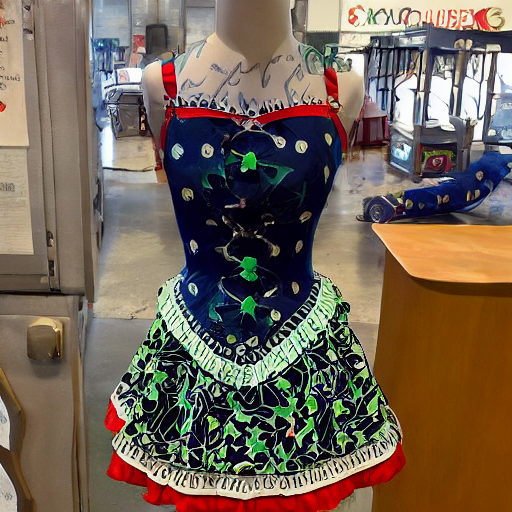

In [186]:
generate_with_concept_and_guidance("A kid dancing on the beach", "<line-art>", 32, airplane_guidance_scale=10)

In [105]:
# =============================================
# PART 5: Generate images with all concepts
# =============================================

def generate_all_concept_images(base_prompt, output_dir="outputs"):
    """Generate images using all concepts with the same base prompt"""
    os.makedirs(output_dir, exist_ok=True)
    
    results = {}
    seeds = [246, 47, 32, 98, 176]  # Use different seeds for each concept
    
    for i, (concept, seed) in enumerate(zip(concepts, seeds)):
        # Generate with concept only
        image_concept = generate_with_concept_and_guidance(
            base_prompt, 
            concept, 
            seed,
            airplane_guidance_scale=0  # No airplane guidance
        )
        concept_filename = f"{output_dir}/{concept.strip('<>')}_only.png"
        image_concept.save(concept_filename)
        
        # Generate with concept + airplane guidance
        image_guided = generate_with_concept_and_guidance(
            base_prompt, 
            concept, 
            seed, 
            airplane_guidance_scale=airplane_guidance_scale
        )
        guided_filename = f"{output_dir}/{concept.strip('<>')}_with_airplane_guidance.png"
        image_guided.save(guided_filename)
        
        results[concept] = {
            "seed": seed,
            "concept_only": concept_filename,
            "with_guidance": guided_filename
        }
        
        print(f"Generated images for {concept} (Seed: {seed})")
        break # Remove this to generate for all concepts
    
    return results

In [55]:
# =============================================
# Use your base prompt
base_prompt = "A dog at the beach"

# Generate images for all concepts
results = generate_all_concept_images(base_prompt)

# Display results summary
print("\nGeneration Complete! Summary:")
for concept, info in results.items():
    print(f"{concept} (Seed: {info['seed']}):")
    print(f"  - Concept only: {info['concept_only']}")
    print(f"  - With airplane guidance: {info['with_guidance']}")
    break

Generating: A dog at the beach puppy (replacing puppy with <anime-background-style-v2>)
Replaced puppy token with <anime-background-style-v2> embedding


  6%|▌         | 3/50 [00:00<00:05,  8.28it/s]

Step 0, airplane guidance loss: -0.0


 26%|██▌       | 13/50 [00:01<00:03, 10.33it/s]

Step 10, airplane guidance loss: -0.0


 46%|████▌     | 23/50 [00:02<00:02, 10.30it/s]

Step 20, airplane guidance loss: -0.0


 66%|██████▌   | 33/50 [00:03<00:01, 10.28it/s]

Step 30, airplane guidance loss: -0.0


 86%|████████▌ | 43/50 [00:04<00:00, 10.21it/s]

Step 40, airplane guidance loss: -0.0


100%|██████████| 50/50 [00:05<00:00,  9.72it/s]


Generating: A dog at the beach puppy (replacing puppy with <anime-background-style-v2>)
Replaced puppy token with <anime-background-style-v2> embedding


  4%|▍         | 2/50 [00:00<00:03, 15.46it/s]

Step 0, airplane guidance loss: -0.4518444538116455


 24%|██▍       | 12/50 [00:01<00:03, 10.10it/s]

Step 10, airplane guidance loss: -3.7674694061279297


 46%|████▌     | 23/50 [00:02<00:02,  9.90it/s]

Step 20, airplane guidance loss: -8.735405921936035


 66%|██████▌   | 33/50 [00:03<00:01, 10.16it/s]

Step 30, airplane guidance loss: -15.34415340423584


 86%|████████▌ | 43/50 [00:04<00:00, 10.25it/s]

Step 40, airplane guidance loss: -21.870094299316406


100%|██████████| 50/50 [00:04<00:00, 10.02it/s]


Generated images for <anime-background-style-v2> (Seed: 246)

Generation Complete! Summary:
<anime-background-style-v2> (Seed: 246):
  - Concept only: outputs/anime-background-style-v2_only.png
  - With airplane guidance: outputs/anime-background-style-v2_with_airplane_guidance.png
